In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.model_mse import MultiDecoderCondVAE, integrated_loss_fn


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_loader = torch.load('torch/train_loader.pt',weights_only=False)
val_loader = torch.load('torch/val_loader.pt',weights_only= False)
test_loader = torch.load('torch/test_loader.pt',weights_only= False)

In [4]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]


In [5]:
model = MultiDecoderCondVAE(x_dim,c_dim,z_dim=16,z1_dim=32).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

In [6]:
history = {'train_loss':[],'train_mse':[],'train_kl':[],'val_loss':[],'val_mse':[],'val_kl':[]}
epochs = 300

In [7]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss,t_mse,t_kl = 0,0,0
    beta = 0.01
    for x,c in train_loader:
        x,c = x.to(device),c.to(device)
        optimizer.zero_grad()
        mask_logits,prob_mask,mask_out,recon_numeric,z_mu,z_logvar = model(x,c)
        loss_dict = integrated_loss_fn(mask_logits, recon_numeric,x,z_mu,z_logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss += loss_dict['loss'].item()
        t_mse += loss_dict['mse'].item()
        t_kl += loss_dict['kl_loss'].item()
    model.eval()
    v_loss = 0
    v_mse = 0
    v_kl = 0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_mask_logits,v_prob_mask,v_mask_out,v_recon_numeric,v_z_mu,v_z_logvar = model(v_x,v_c)
            loss_dict = integrated_loss_fn(v_mask_logits, v_recon_numeric,v_x,v_z_mu,v_z_logvar)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['mse'].item()
            v_kl += loss_dict['kl_loss'].item()
    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_mse'].append(t_mse/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_mse'].append(v_mse/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break



Epoch [2/300]|Train:12.7027 |Val:7.4866
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [20/300]|Train:1.8846 |Val:1.8577
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [40/300]|Train:1.3948 |Val:1.5209
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Early

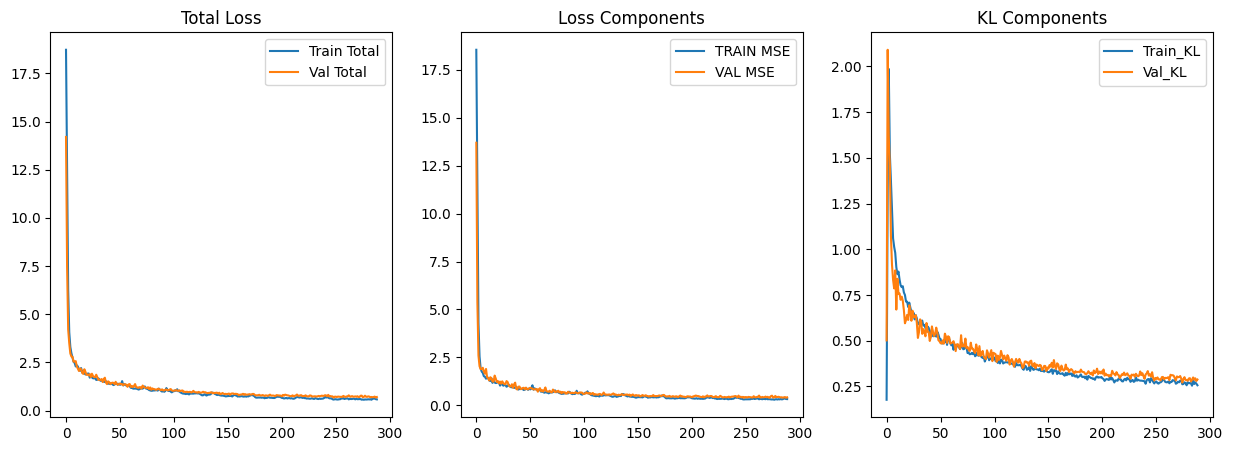

In [8]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_mse'], label='TRAIN MSE')
plt.plot(history['val_mse'], label='VAL MSE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

In [9]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 1) 환경 및 데이터 준비
x_scaler = joblib.load('./torch/x_scaler.pkl')
test_loader = torch.load('torch/test_loader.pt', weights_only=False)

early_stopping.load_best_model(model)
model.eval()

all_x_true = [] #실제값(Scaled)
all_x_pred = [] # 복원값(Scaled)
all_mask_prob = [] # 존재확률 [0,1]
all_c_condition = [] # 사용된 조건(c)

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)

        mask_logits,prob_mask,_,recon_numeric,_,_= model(x_t,c_t)
        final_recon = recon_numeric*prob_mask

        #확률 및 최종 복원값 계산
        prob_mask = torch.sigmoid(mask_logits)
        all_x_true.append(x_t.cpu().numpy())
        all_x_pred.append(final_recon.cpu().numpy())
        all_mask_prob.append(prob_mask.cpu().numpy())
        all_c_condition.append(c_t.cpu().numpy())

all_x_true = np.vstack(all_x_true)
all_x_pred = np.vstack(all_x_pred)
all_x_pred = np.maximum(all_x_pred,0)
all_mask_prob = np.vstack(all_mask_prob)

x_true_raw = x_scaler.inverse_transform(all_x_true)
x_recon_raw = x_scaler.inverse_transform(all_x_pred)



from sklearn.metrics import r2_score, mean_squared_error
x_true = x_true_raw.flatten()
x_pred = x_recon_raw.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
r2

Restored best model with loss: 0.674948


-0.8168100118637085

In [22]:
mask_logits

tensor([[-8.5695e-02,  1.3454e-01,  2.1792e-01,  5.8377e-02,  2.0826e-01,
         -8.3197e-02, -1.9363e-01,  1.8811e-01,  5.1160e-02,  1.3719e-01,
         -1.9768e-01,  4.6147e-02, -7.0298e-02,  8.5146e-03, -1.9343e-02,
          7.2667e-02,  5.4259e-02, -4.2423e-02,  1.0512e-01,  1.4612e-01,
         -4.9683e-03,  7.0859e-02,  1.4036e-01],
        [-5.9231e-03,  2.2458e-01,  1.2650e-01,  1.5816e-01,  2.5278e-01,
         -4.6361e-02, -2.1068e-01,  1.7071e-01,  5.6652e-02,  4.9980e-02,
         -1.4955e-01,  5.1963e-02, -7.2352e-02,  3.7843e-02,  3.5857e-02,
          1.6299e-01,  2.2717e-02, -7.2703e-02,  1.8835e-01,  1.7195e-01,
          9.1584e-03,  1.3661e-01,  6.1353e-02],
        [-1.0952e-01,  1.5494e-01,  1.6049e-01,  1.2242e-01,  1.9333e-01,
         -5.0518e-02, -1.8804e-01,  1.0500e-01,  5.7154e-02,  1.0072e-01,
         -2.1635e-01, -1.5214e-02, -1.1030e-01, -1.1378e-02, -2.6853e-02,
          1.1020e-01,  1.7908e-02, -5.2099e-02,  1.0366e-01,  5.1746e-02,
         -2.87

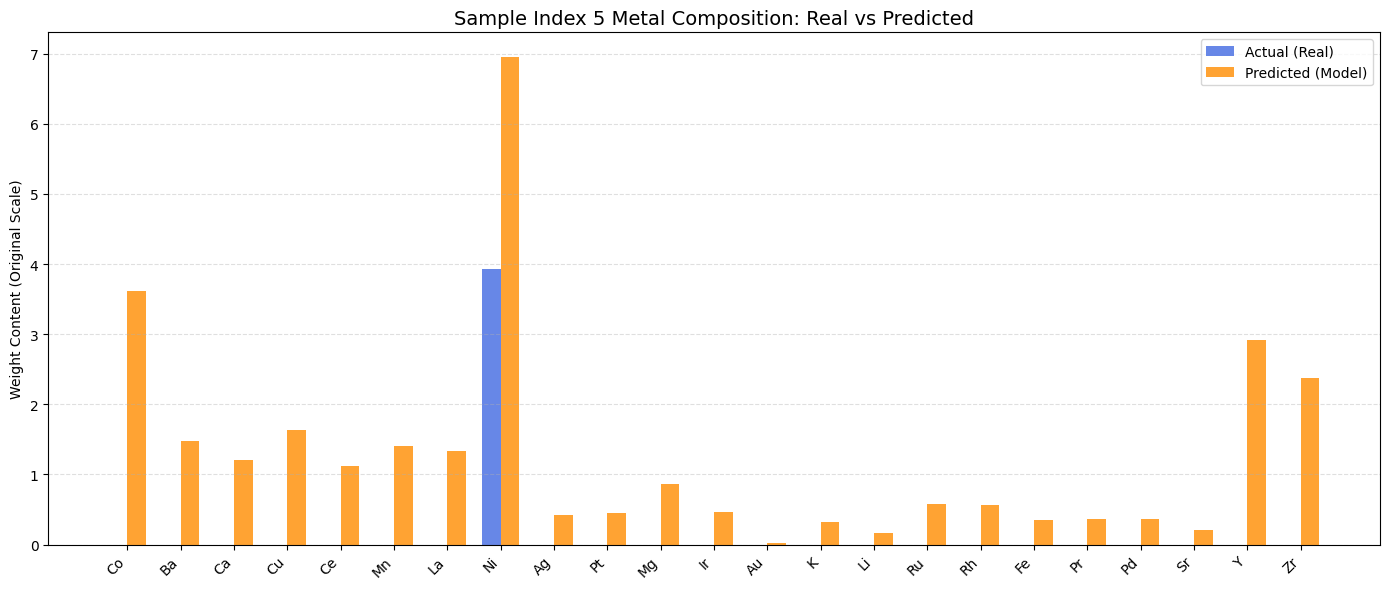

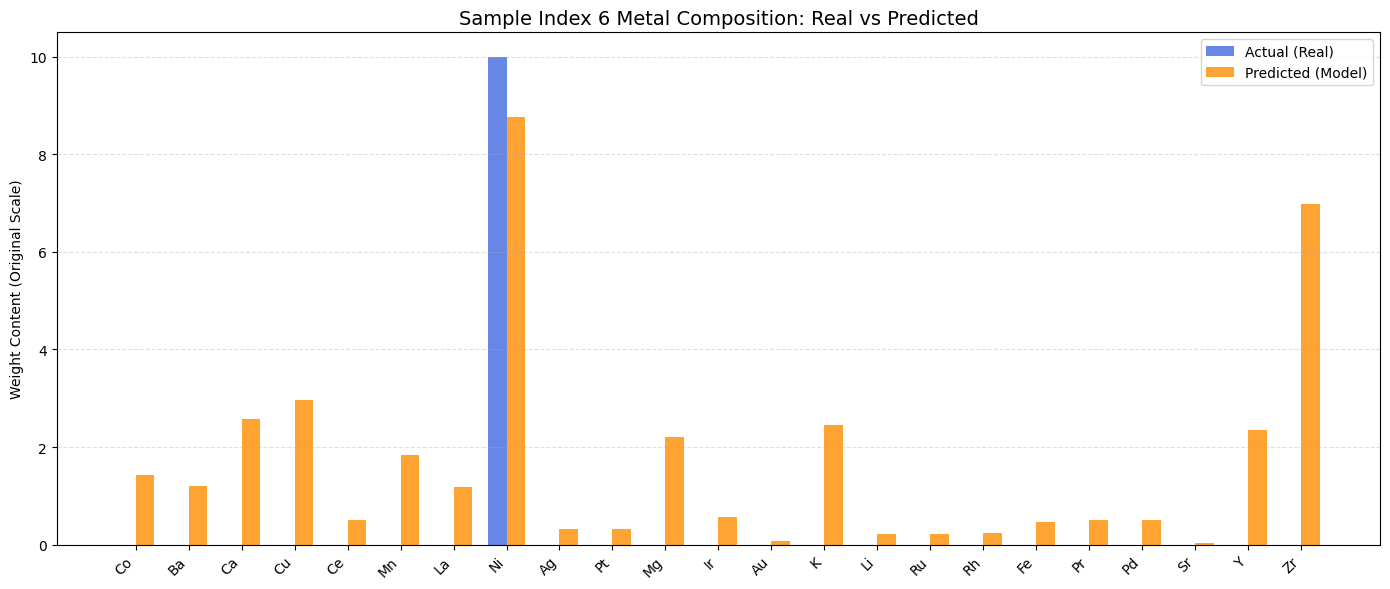

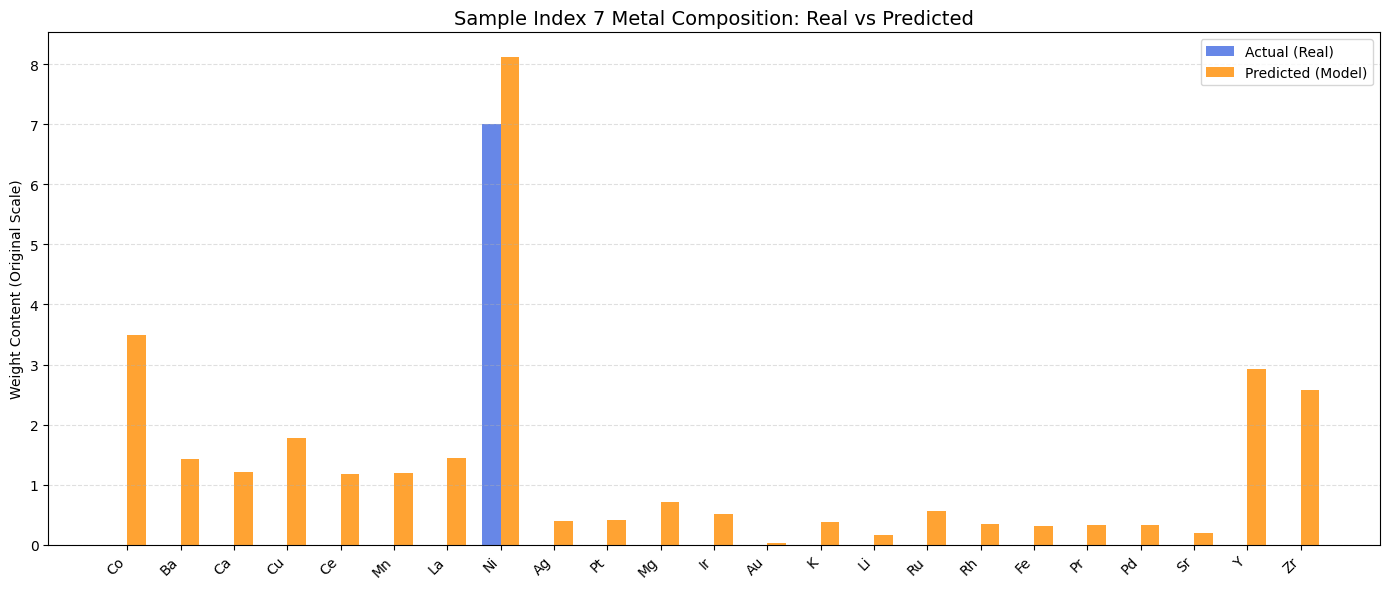

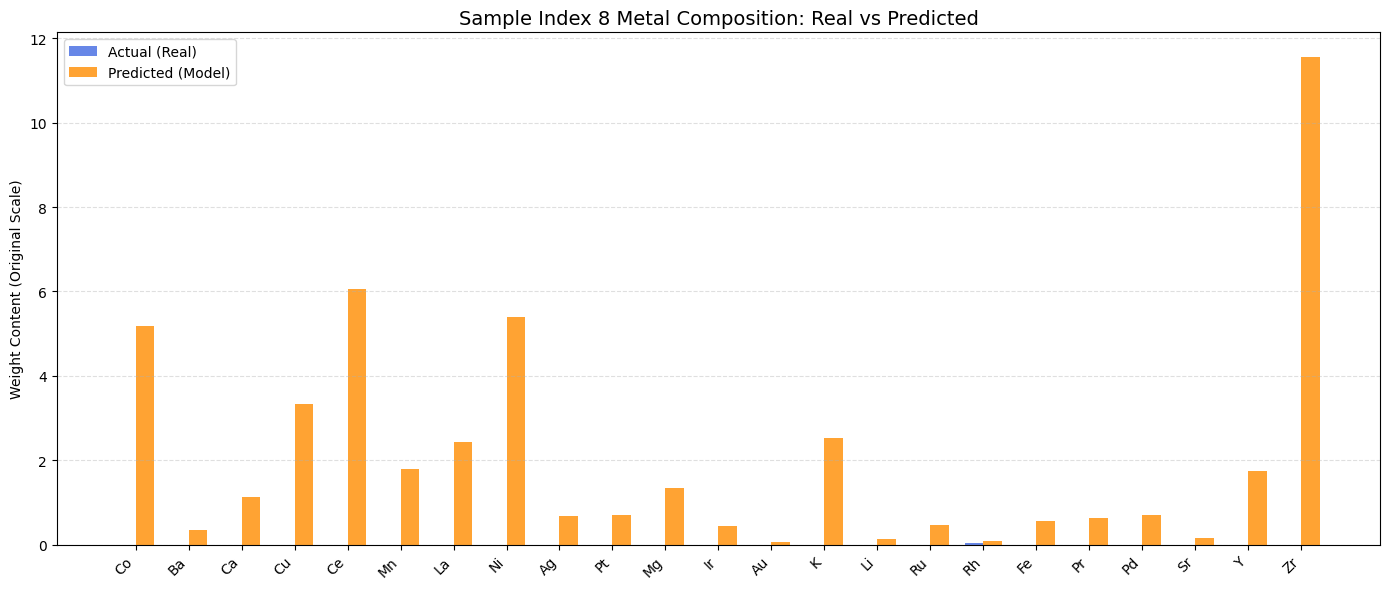

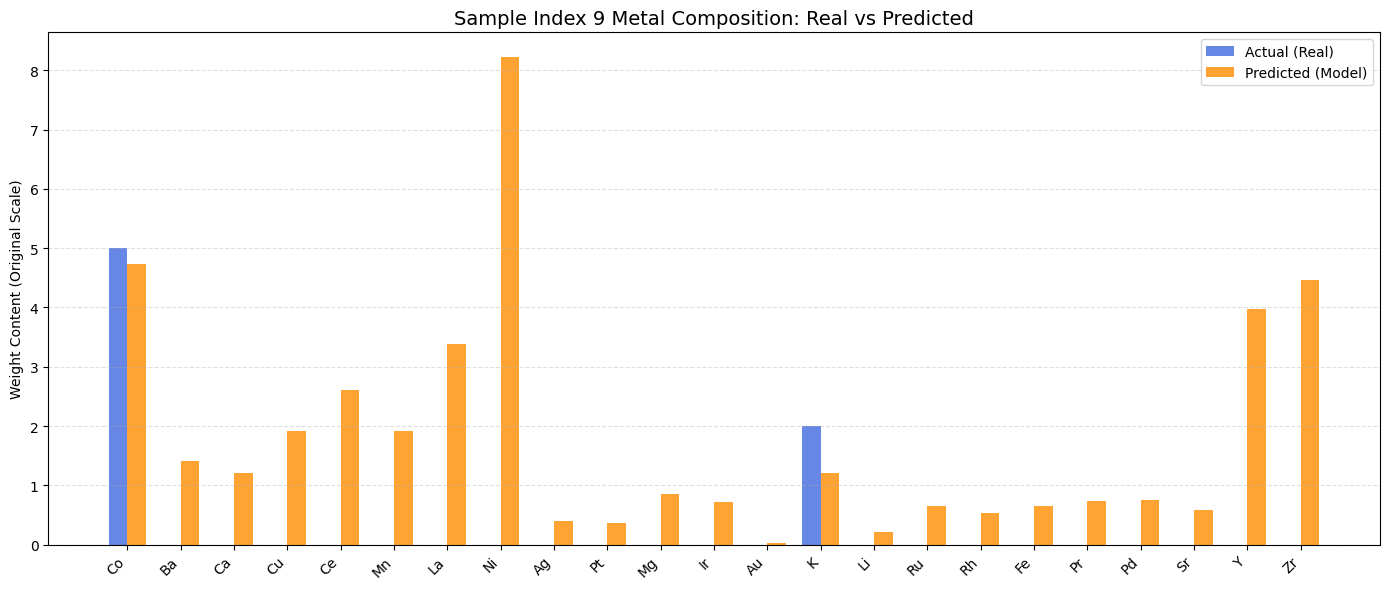

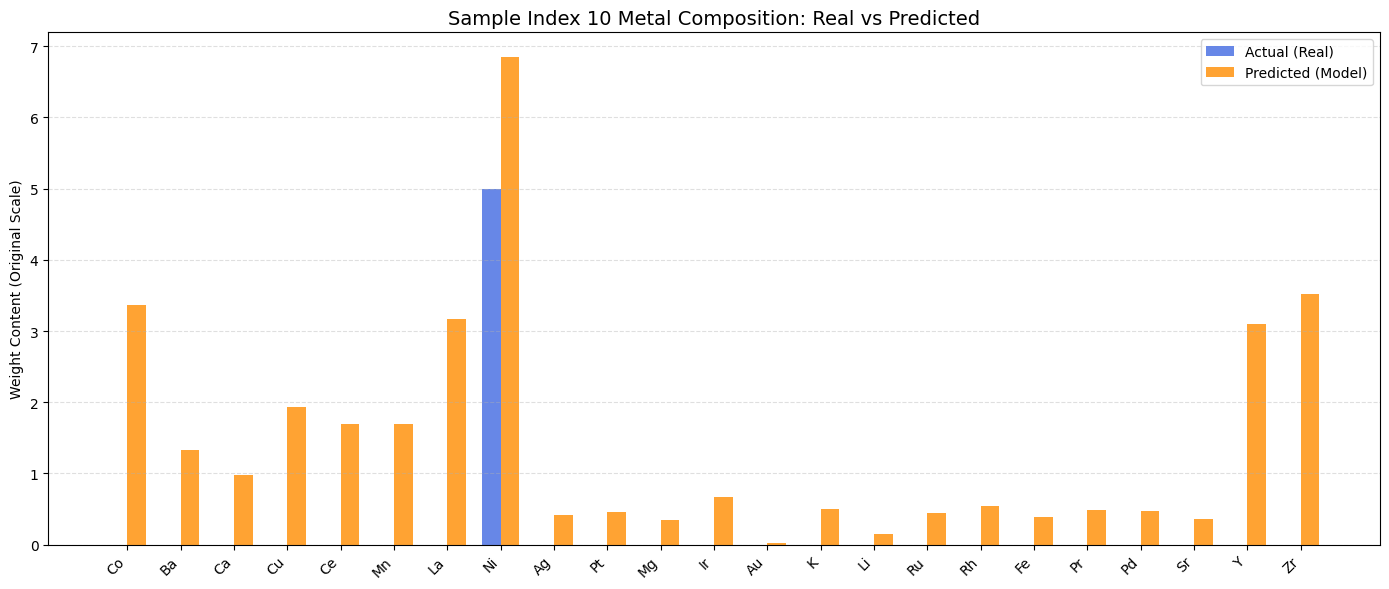

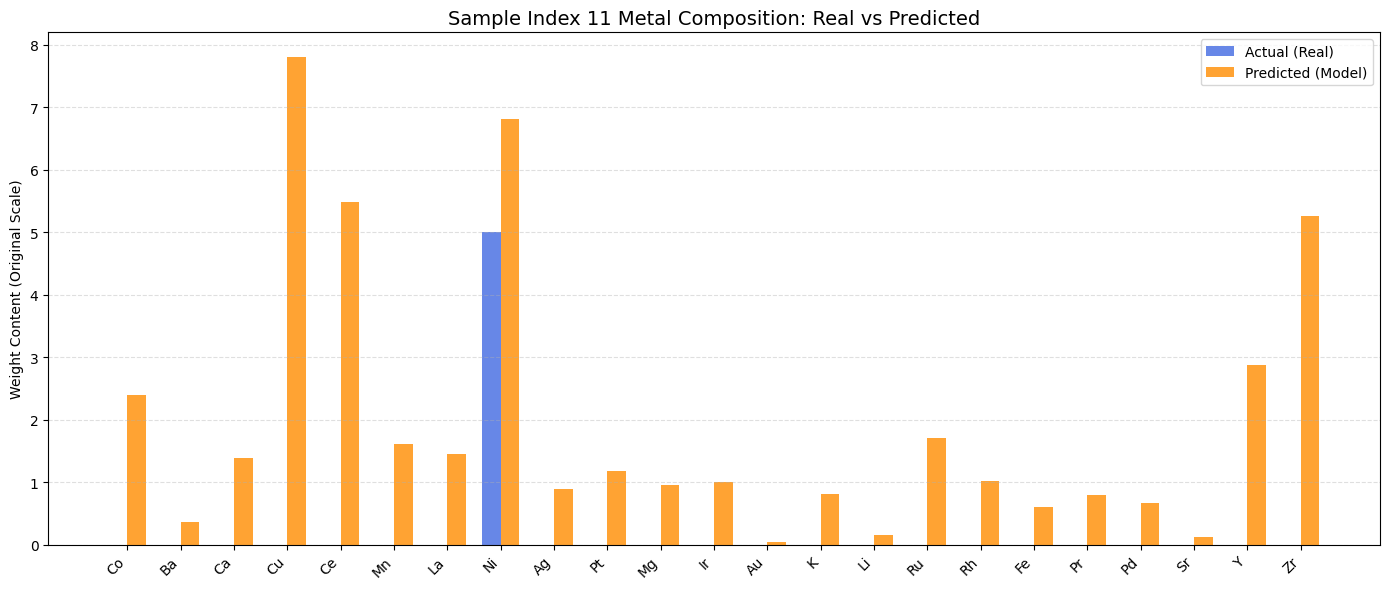

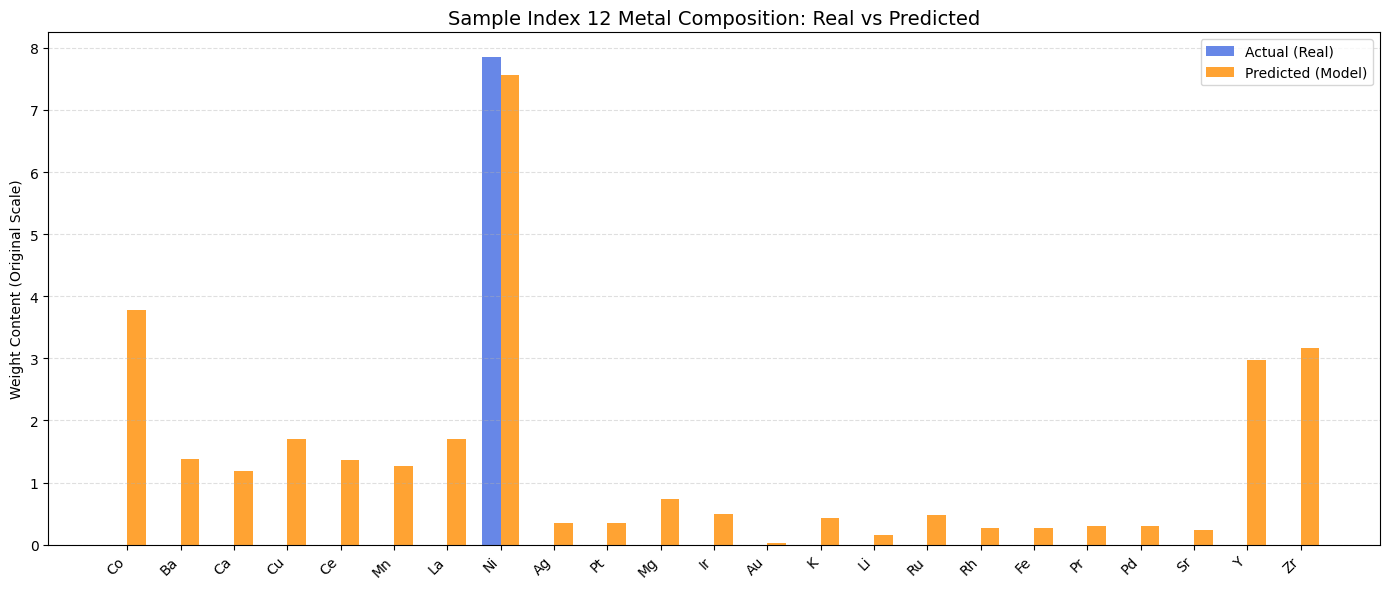

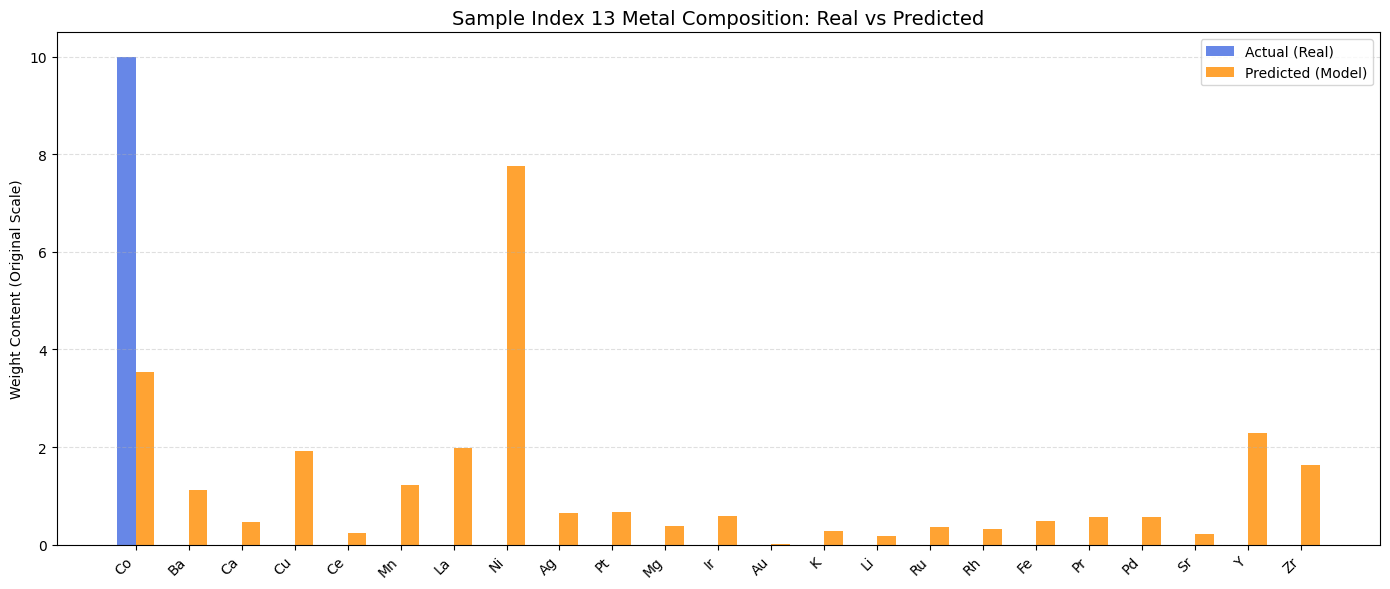

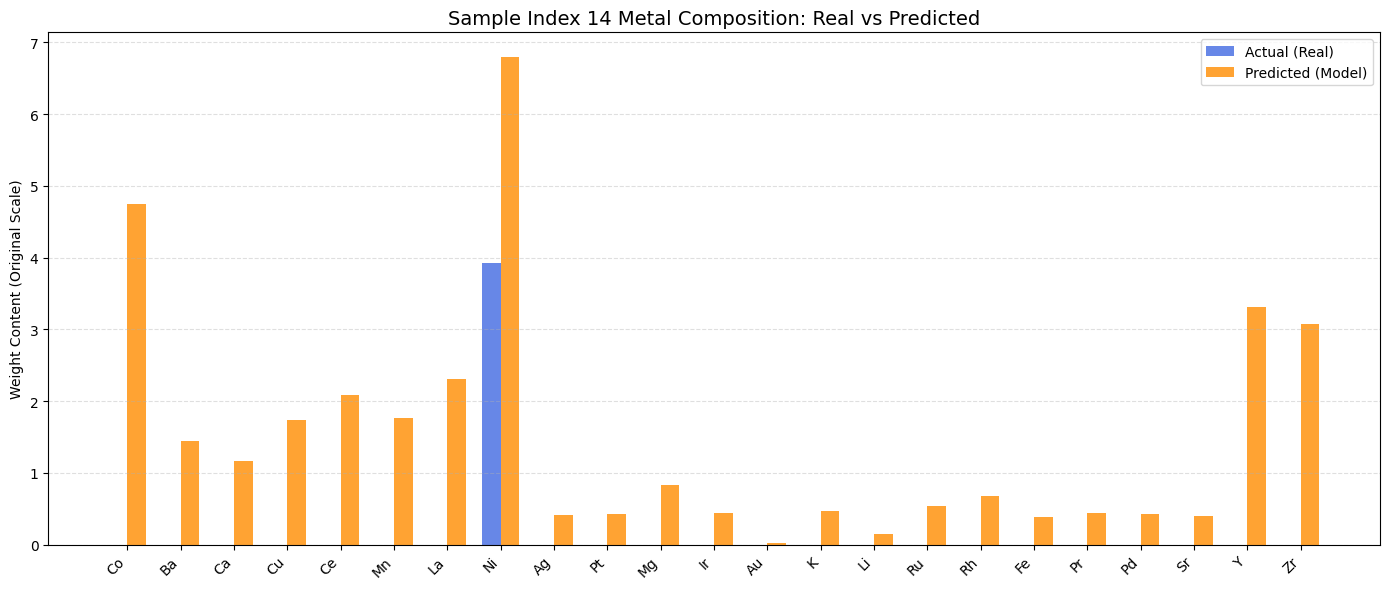

In [11]:
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.35
    
    plt.bar(x_axis - width/2, x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_recon_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()